Exploratory Data Analysis for 2017 Boston Marathon result

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
%matplotlib inline

df_2017 = pd.read_csv(r'./marathon_results_2017.csv')
print(df_2017.shape)
print(df_2017.info())

(26410, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26410 entries, 0 to 26409
Data columns (total 25 columns):
Unnamed: 0       26410 non-null int64
Bib              26410 non-null object
Name             26410 non-null object
Age              26410 non-null int64
M/F              26410 non-null object
City             26410 non-null object
State            22815 non-null object
Country          26410 non-null object
Citizen          1254 non-null object
Unnamed: 9       91 non-null object
5K               26410 non-null object
10K              26410 non-null object
15K              26410 non-null object
20K              26410 non-null object
Half             26410 non-null object
25K              26410 non-null object
30K              26410 non-null object
35K              26410 non-null object
40K              26410 non-null object
Pace             26410 non-null object
Proj Time        26410 non-null object
Official Time    26410 non-null object
Overall          26410 non-

Data cleaning

In [2]:
df_2017.rename(columns = {'Unnamed: 0':'Rank'}, inplace = True)

# No values on the column below. Removed.
df_2017 = df_2017.drop('Proj Time', axis=1)

# Convert time data for later analysis
df_2017.loc[:,'5K':'Official Time'] = df_2017.loc[:,'5K':'Official Time'].astype(str)

# Find invalid rows with '-'. Probability data was not detected by machine, or the runners took the shortcuts...
b_invalid = df_2017.loc[:,'5K'].str.contains('-') | df_2017.loc[:,'10K'].str.contains('-') | df_2017.loc[:,'15K'].str.contains('-')\
    | df_2017.loc[:,'20K'].str.contains('-') | df_2017.loc[:,'25K'].str.contains('-') | df_2017.loc[:,'25K'].str.contains('-')\
    | df_2017.loc[:,'30K'].str.contains('-') | df_2017.loc[:,'35K'].str.contains('-') | df_2017.loc[:,'40K'].str.contains('-')\
    | df_2017.loc[:,'Official Time'].str.contains('-')
print(b_invalid[ b_invalid==True]) # 148 rows with missing running data

df_2017 = df_2017.drop(df_2017.loc[b_invalid,:].index)
print(df_2017.shape)

231      True
366      True
862      True
1389     True
1545     True
1574     True
2131     True
2301     True
2482     True
2608     True
3038     True
3176     True
3199     True
3564     True
3614     True
3690     True
3807     True
4158     True
4198     True
4513     True
4899     True
5048     True
5050     True
5267     True
5378     True
5426     True
5966     True
5972     True
6047     True
6267     True
         ... 
22576    True
22634    True
22691    True
22988    True
23011    True
23136    True
23167    True
23180    True
23250    True
23461    True
23587    True
23608    True
23643    True
23809    True
24145    True
24146    True
24403    True
24498    True
24576    True
25094    True
25414    True
25431    True
25517    True
25828    True
25940    True
26088    True
26121    True
26132    True
26189    True
26407    True
Length: 148, dtype: bool
(26262, 24)


Convert time data from string to time type

In [3]:
columns = df_2017.loc[:,'5K':'Official Time'].columns

for col in columns:
    df_2017.loc[:, col] = pd.to_timedelta(df_2017.loc[:, col])

In [4]:
df = pd.DataFrame(columns = ['0-5K','5-10K','10-15K','15-20K','20-25K','25-30K','30-35K','35-42K'])

df['0-5K'] = df_2017.loc[:,'5K']
df['5-10K'] = df_2017.loc[:,'10K']  - df_2017.loc[:,'5K']
df['10-15K'] = df_2017.loc[:,'15K']  - df_2017.loc[:,'10K'] 
df['15-20K'] = df_2017.loc[:,'20K']  - df_2017.loc[:,'15K'] 
df['20-25K'] = df_2017.loc[:,'25K']  - df_2017.loc[:,'20K'] 
df['25-30K'] = df_2017.loc[:,'30K']  - df_2017.loc[:,'25K'] 
df['30-35K'] = df_2017.loc[:,'35K']  - df_2017.loc[:,'30K']
df['35-42K'] = df_2017.loc[:,'Official Time']  - df_2017.loc[:,'35K']
df['Official Time'] = df_2017.loc[:,'Official Time']
print(df.head())

      0-5K    5-10K   10-15K   15-20K   20-25K   25-30K   30-35K   35-42K  \
0 00:15:25 00:15:03 00:15:16 00:15:31 00:15:44 00:16:02 00:15:18 00:21:18   
1 00:15:24 00:15:03 00:15:17 00:15:31 00:15:44 00:16:02 00:15:18 00:21:39   
2 00:15:25 00:15:04 00:15:15 00:15:32 00:15:44 00:16:01 00:15:30 00:21:57   
3 00:15:25 00:15:04 00:15:15 00:15:35 00:15:41 00:16:01 00:15:57 00:23:10   
4 00:15:25 00:15:03 00:15:16 00:15:31 00:15:44 00:16:02 00:15:40 00:23:54   

  Official Time  
0      02:09:37  
1      02:09:58  
2      02:10:28  
3      02:12:08  
4      02:12:35  


Convert h:m:s to seconds

In [5]:
columns= df.loc[:,'0-5K':'Official Time'].columns

for col in columns:
    df[col] = pd.to_timedelta(df.loc[:, col]).dt.total_seconds()
    
# Add Age and M/F to df dataframe
df['Age'] = df_2017['Age']
df['M/F'] = df_2017['M/F']

print(df.head())

    0-5K  5-10K  10-15K  15-20K  20-25K  25-30K  30-35K  35-42K  \
0  925.0  903.0   916.0   931.0   944.0   962.0   918.0  1278.0   
1  924.0  903.0   917.0   931.0   944.0   962.0   918.0  1299.0   
2  925.0  904.0   915.0   932.0   944.0   961.0   930.0  1317.0   
3  925.0  904.0   915.0   935.0   941.0   961.0   957.0  1390.0   
4  925.0  903.0   916.0   931.0   944.0   962.0   940.0  1434.0   

   Official Time  Age M/F  
0         7777.0   24   M  
1         7798.0   30   M  
2         7828.0   25   M  
3         7928.0   32   M  
4         7955.0   31   M  


Statistics for number of runners by gender. Men runners are 9.28% more than women.

In [6]:
n_male = df_2017[df_2017['M/F'] == 'M'].shape[0]
n_female = df_2017[df_2017['M/F'] == 'F'].shape[0]

print('Total number of men: ', n_male, '/ {0:.2f}'.format(n_male / df_2017.shape[0] * 100),'%\n')
print('Total number of women: ', n_female, '/ {0:.2f}'.format(n_female / df_2017.shape[0] * 100),'%')

Total number of men:  14349 / 54.64 %

Total number of women:  11913 / 45.36 %


From the box chart below by different age range (x-axis), the best average times are quite similar from age 25 to 39. The total time gradually increases when age is greater than 40. Boston marathon is the most famous one which requires strict qualifying time: https://www.baa.org/races/boston-marathon/enter/qualify/history-qualifying-times. The fastest (most strict) time is for runners below age 35 (Men: 3hrs 10min, Women: 3hrs 40min) then increase 5 - 15 mins every five years old.

    0-5K  5-10K  10-15K  15-20K  20-25K  25-30K  30-35K  35-42K  \
0  925.0  903.0   916.0   931.0   944.0   962.0   918.0  1278.0   
1  924.0  903.0   917.0   931.0   944.0   962.0   918.0  1299.0   
2  925.0  904.0   915.0   932.0   944.0   961.0   930.0  1317.0   
3  925.0  904.0   915.0   935.0   941.0   961.0   957.0  1390.0   
4  925.0  903.0   916.0   931.0   944.0   962.0   940.0  1434.0   

   Official Time  Age M/F Age_range  
0         7777.0   24   M       <25  
1         7798.0   30   M     30-34  
2         7828.0   25   M     25-29  
3         7928.0   32   M     30-34  
4         7955.0   31   M     30-34  


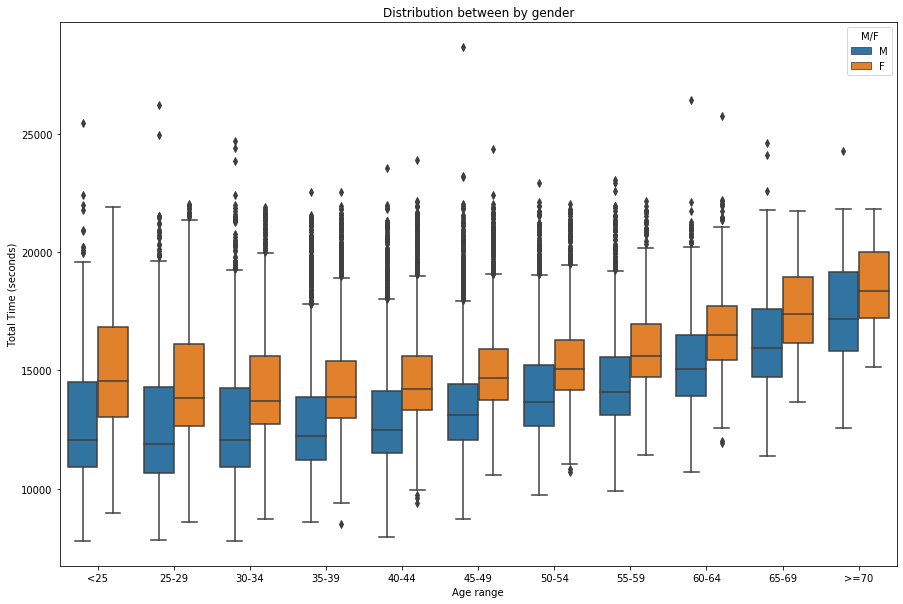

In [7]:
df.loc[df_2017['Age'] < 25, 'Age_range'] = '<25'
df.loc[(df_2017['Age'] >= 25)&(df_2017['Age'] < 30), 'Age_range'] = '25-29'
df.loc[(df_2017['Age'] >= 30)&(df_2017['Age'] < 35), 'Age_range'] = '30-34'
df.loc[(df_2017['Age'] >= 35)&(df_2017['Age'] < 40), 'Age_range'] = '35-39'
df.loc[(df_2017['Age'] >= 40)&(df_2017['Age'] < 45), 'Age_range'] = '40-44'
df.loc[(df_2017['Age'] >= 45)&(df_2017['Age'] < 50), 'Age_range'] = '45-49'
df.loc[(df_2017['Age'] >= 50)&(df_2017['Age'] < 55), 'Age_range'] = '50-54'
df.loc[(df_2017['Age'] >= 55)&(df_2017['Age'] < 60), 'Age_range'] = '55-59'
df.loc[(df_2017['Age'] >= 60)&(df_2017['Age'] < 65), 'Age_range'] = '60-64'
df.loc[(df_2017['Age'] >= 65)&(df_2017['Age'] < 70), 'Age_range'] = '65-69'
df.loc[(df_2017['Age'] >= 70), 'Age_range'] = '>=70'

print(df.head())
plt.figure(figsize = (15,10))
sns.boxplot(x = 'Age_range', y = 'Official Time', data = df, hue = 'M/F',\
           order = ["<25", "25-29","30-34","35-39","40-44","45-49","50-54","55-59","60-64","65-69",">=70"])
plt.title('Distribution between by gender')
plt.xlabel('Age range')
plt.ylabel('Total Time (seconds)')
plt.show()

The chart below shows the distribution of overall runners' ages including KDE (Kernel Density Estimation) curve.
It shows that ages between 40 - 50 have the most participants.

Text(0, 0.5, 'Density')

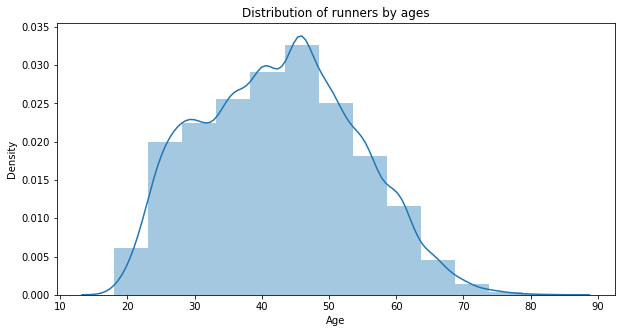

In [8]:
plt.figure(figsize = (10,5))
sns.distplot(df['Age'], bins = 13)
plt.title('Distribution of runners by ages')
plt.xlabel('Age')
plt.ylabel('Density')

The chart below shows the distribution (by count) of the runners by gender.
There are much more female runners than male below age 30. T
The totals parcipatants between men and women are close between age 30 to 40. 
Total number s of male runners are much more than female above age 43.

Text(0, 0.5, 'Count')

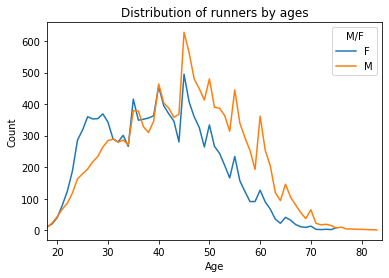

In [9]:
df_2017.pivot_table(values = 'Bib', index='Age', columns='M/F', aggfunc = 'count').plot(kind = 'line', stacked = False)
plt.title('Distribution of runners by ages')
plt.xlabel('Age')
plt.ylabel('Count')

Top 100 runners for men and women. Majority are from USA - 75% for men and 78% for women.

In [10]:
df_m = df_2017[df_2017['M/F'] =='M'].head(100)
print('Men top 100 runners by Country\n')
print(df_m['Country'].value_counts(),'\n\n')

df_m = df_2017[df_2017['M/F'] =='F'].head(100)
print('Women top 100 runners by Country\n')
print(df_m['Country'].value_counts(),'\n')

Men top 100 runners by Country

USA    75
CAN     5
KEN     4
JPN     4
GER     2
MEX     2
ETH     2
BRA     1
ZIM     1
NED     1
GBR     1
IRL     1
ITA     1
Name: Country, dtype: int64 


Women top 100 runners by Country

USA    78
KEN     4
CAN     4
AUS     3
ETH     3
JPN     2
GBR     1
BDI     1
ESP     1
BRN     1
MEX     1
GER     1
Name: Country, dtype: int64 



Also, as expected, runners from Kenya and Ethiopia are all top runners!

In [11]:
print('Results for all runners from Kenya and Ethopia:\n')
print(df_2017.loc[(df_2017['Country'] == 'KEN') | (df_2017['Country'] == 'ETH'), ['Overall', 'M/F', 'Official Time']]\
      .to_string(index = False))

Results for all runners from Kenya and Ethopia:

 Overall M/F Official Time
       1   M      02:09:37
       5   M      02:12:35
       8   M      02:14:26
      12   M      02:16:47
      15   M      02:18:14
      18   M      02:19:33
      21   F      02:21:52
      44   F      02:27:20
      54   F      02:29:35
      63   F      02:30:58
      70   F      02:31:48
      85   F      02:33:26
     190   F      02:40:07


The overall ages for male are older than female. Men is 4.9 years older than female in average ages.

Average age for male is 44.8
Average age for female is 39.9


Text(0.5, 0, 'Gender')

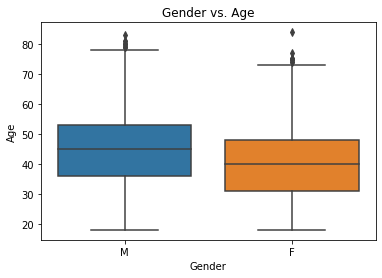

In [12]:
sns.boxplot(x='M/F', y='Age', data=df_2017)
print('Average age for male is', '{0:.1f}'.format(df_2017.loc[df_2017['M/F'] == 'M', 'Age'].mean()))
print('Average age for female is', '{:.1f}'.format(df_2017.loc[df_2017['M/F'] == 'F', 'Age'].mean()))
plt.title('Gender vs. Age')
plt.xlabel('Gender')

Now, let's focus on the comparisons of the average paces across different distance ranges distributions.

The following are the list of my hypothesis/ questions:
* Is there obvious difference on pace stabilities between the top runners and average runners?
* Given that a more stable pace during, say, the first 2/3 km, will the runner get better result?

I will confirm both in the following code.

In [13]:
print(df.head())

    0-5K  5-10K  10-15K  15-20K  20-25K  25-30K  30-35K  35-42K  \
0  925.0  903.0   916.0   931.0   944.0   962.0   918.0  1278.0   
1  924.0  903.0   917.0   931.0   944.0   962.0   918.0  1299.0   
2  925.0  904.0   915.0   932.0   944.0   961.0   930.0  1317.0   
3  925.0  904.0   915.0   935.0   941.0   961.0   957.0  1390.0   
4  925.0  903.0   916.0   931.0   944.0   962.0   940.0  1434.0   

   Official Time  Age M/F Age_range  
0         7777.0   24   M       <25  
1         7798.0   30   M     30-34  
2         7828.0   25   M     25-29  
3         7928.0   32   M     30-34  
4         7955.0   31   M     30-34  


Calculate pace across various distance ranges.

In [14]:
dis = 5
df['Pace_5k'] = df.loc[:,'0-5K'] / dis
df['Pace_10k'] = df.loc[:,'5-10K'] / dis
df['Pace_15k'] = df.loc[:,'10-15K'] / dis
df['Pace_20k'] = df.loc[:,'15-20K'] / dis
df['Pace_25k'] = df.loc[:,'20-25K'] / dis
df['Pace_30k'] = df.loc[:,'25-30K'] / dis
df['Pace_35k'] = df.loc[:,'30-35K'] / dis
df['Pace_42k'] = df.loc[:,'35-42K'] / (dis + 2.195)

print(df.head())

    0-5K  5-10K  10-15K  15-20K  20-25K  25-30K  30-35K  35-42K  \
0  925.0  903.0   916.0   931.0   944.0   962.0   918.0  1278.0   
1  924.0  903.0   917.0   931.0   944.0   962.0   918.0  1299.0   
2  925.0  904.0   915.0   932.0   944.0   961.0   930.0  1317.0   
3  925.0  904.0   915.0   935.0   941.0   961.0   957.0  1390.0   
4  925.0  903.0   916.0   931.0   944.0   962.0   940.0  1434.0   

   Official Time  Age M/F Age_range  Pace_5k  Pace_10k  Pace_15k  Pace_20k  \
0         7777.0   24   M       <25    185.0     180.6     183.2     186.2   
1         7798.0   30   M     30-34    184.8     180.6     183.4     186.2   
2         7828.0   25   M     25-29    185.0     180.8     183.0     186.4   
3         7928.0   32   M     30-34    185.0     180.8     183.0     187.0   
4         7955.0   31   M     30-34    185.0     180.6     183.2     186.2   

   Pace_25k  Pace_30k  Pace_35k    Pace_42k  
0     188.8     192.4     183.6  177.623350  
1     188.8     192.4     183.6  180

We'll use the coefficient of variation (CV), also known as relative standard deviation (RSD), is a standardized measure of dispersion of a probability distribution or frequency distribution. It is defined as the ratio of the standard deviation sigma/ mean.
Using it, we can know how stable of the pace for each runner.
From the scatter chart below, it seems that the stability slightly increase when ranks are increasing.

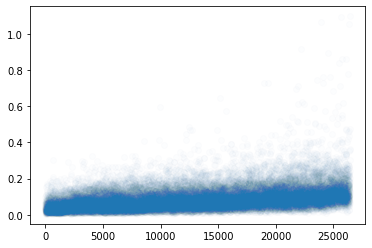

In [15]:
pace_std = df.loc[:,'Pace_5k':'Pace_42k'].std(axis = 1)
pace_mean = df.loc[:,'Pace_5k':'Pace_42k'].mean(axis = 1)

# Calculate coefficient of variation
df['stability'] = pace_std/ pace_mean

# At a glance for the distribution of stability values.
plt.plot(df.index,  df['stability'], 'o', alpha = 0.01)
plt.show()

Take a closer look for by different groups of time result.

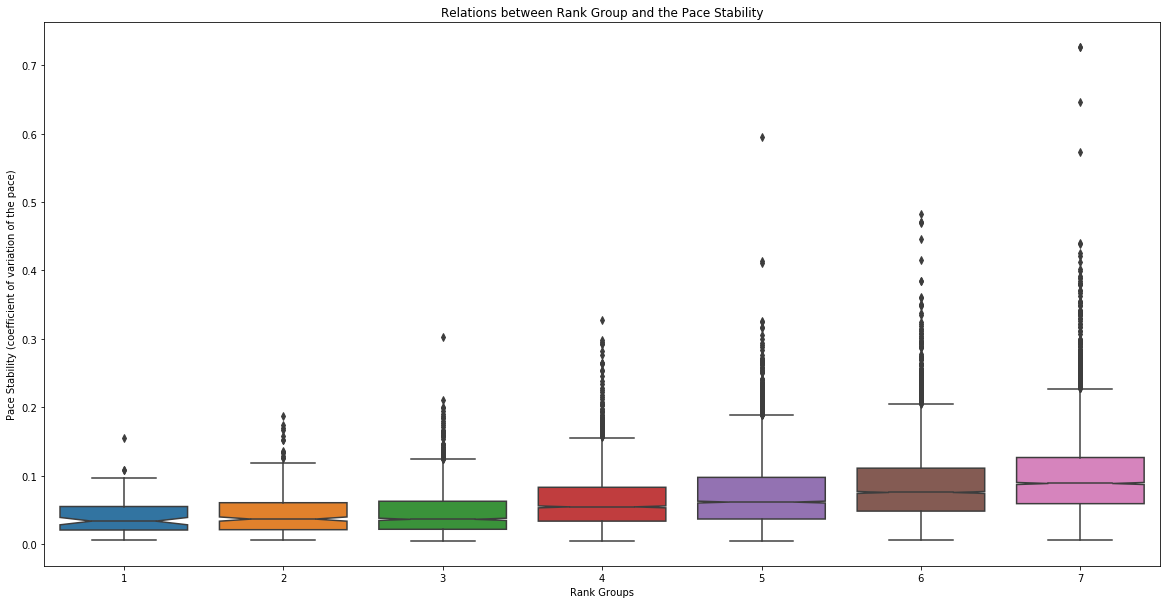

In [16]:
df.loc[0:100, 'Rank_group'] = '1'
df.loc[100:500, 'Rank_group'] = '2'
df.loc[500:2000, 'Rank_group'] = '3'
df.loc[2000:5000, 'Rank_group'] = '4'
df.loc[5000:10000, 'Rank_group'] = '5'
df.loc[10000:15000, 'Rank_group'] = '6'
df.loc[15000:20000, 'Rank_group'] = '7'
df.loc[20000:-1, 'Rank_group'] = '8'
plt.figure(figsize = (20,10))
sns.boxplot(x = df['Rank_group'], y = df['stability'], data = df, notch =True, showfliers = True)
plt.title('Relations between Rank Group and the Pace Stability')
plt.xlabel('Rank Groups')
plt.ylabel('Pace Stability (coefficient of variation of the pace)')
plt.show()

There are some outliers especially in the lower groups, Normally they might be caused for some special reasons such as injuries/illness
during the race so intend to give up the race, etc. As those are not the normal case and will affect the training result, so I remove
them by highest CV (i.e. least stable in pace) value (eg, above 0.95 quantile.) Note that there is no need to remove lowest quantile as they are the normal case espeically include
most of the top runners' data.

In [17]:
print(df.shape)
outliers = df['stability'].quantile(0.95)
print(outliers)
df = df[df['stability'] < outliers]
print(df.shape)

(26262, 22)
0.20191665414472706
(24948, 22)


The boxplot between rank group and the race stability is shown below after removing top 5% of outliers.

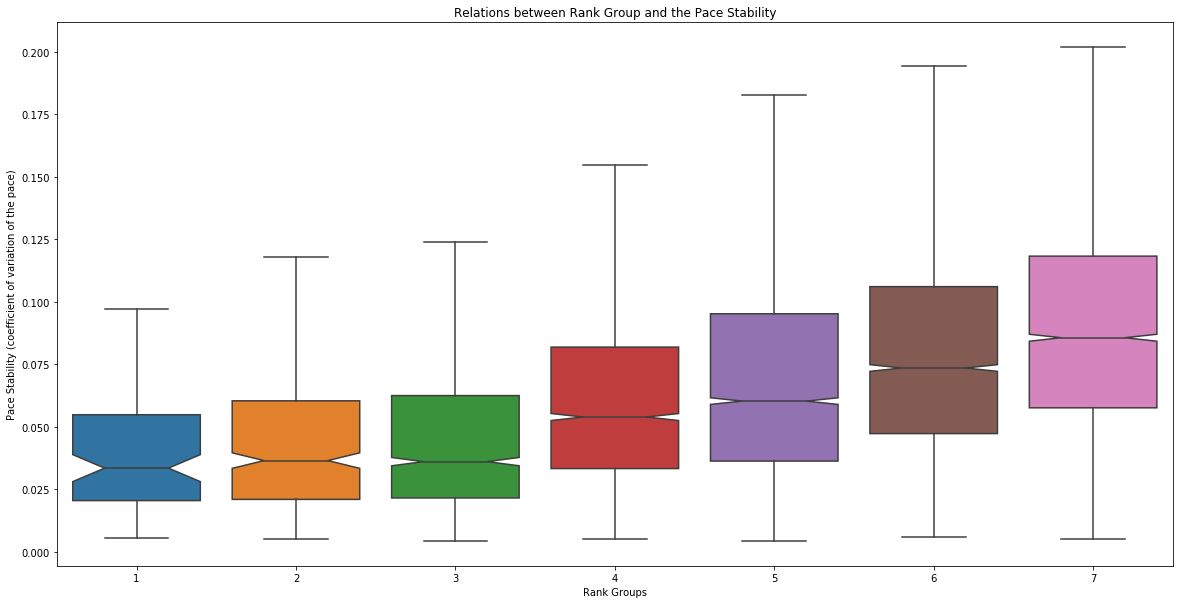

In [18]:
plt.figure(figsize = (20,10))
sns.boxplot(x = df['Rank_group'], y = df['stability'], data = df, notch =True, showfliers = False)
plt.title('Relations between Rank Group and the Pace Stability')
plt.xlabel('Rank Groups')
plt.ylabel('Pace Stability (coefficient of variation of the pace)')
plt.show()

The boxchart above shows that there is strong correction between the result and the pace stability throughout the marathon.
It indicates that the better runner espeically the top 100 runners tend to keep the pace much more stable than other runners.

Now, I use the existing features to see if we can do the rough predictions based on the limited features:
Features: 'Age', 'M/F', 'stability'
Label: Total time

In [19]:
print(df.head())

    0-5K  5-10K  10-15K  15-20K  20-25K  25-30K  30-35K  35-42K  \
0  925.0  903.0   916.0   931.0   944.0   962.0   918.0  1278.0   
1  924.0  903.0   917.0   931.0   944.0   962.0   918.0  1299.0   
2  925.0  904.0   915.0   932.0   944.0   961.0   930.0  1317.0   
3  925.0  904.0   915.0   935.0   941.0   961.0   957.0  1390.0   
4  925.0  903.0   916.0   931.0   944.0   962.0   940.0  1434.0   

   Official Time  Age  ... Pace_5k Pace_10k  Pace_15k  Pace_20k  Pace_25k  \
0         7777.0   24  ...   185.0    180.6     183.2     186.2     188.8   
1         7798.0   30  ...   184.8    180.6     183.4     186.2     188.8   
2         7828.0   25  ...   185.0    180.8     183.0     186.4     188.8   
3         7928.0   32  ...   185.0    180.8     183.0     187.0     188.2   
4         7955.0   31  ...   185.0    180.6     183.2     186.2     188.8   

   Pace_30k  Pace_35k    Pace_42k  stability  Rank_group  
0     192.4     183.6  177.623350   0.024964           1  
1     192.4     

The pace stability feature is calculated from 0 - 30 km

In [20]:
pace_std = df.loc[:,'Pace_5k':'Pace_30k'].std(axis = 1)
pace_mean = df.loc[:,'Pace_5k':'Pace_30k'].mean(axis = 1)

# Calculate coefficient of variation
df['stability'] = pace_std/ pace_mean

In [21]:
X = pd.DataFrame()
y = pd.DataFrame()
X['Age'] = df['Age']
X['M/F'] = df['M/F']
X['stability'] = df['stability']
y['Official Time'] = df['Official Time']
y['Official Time'].astype('int32', inplace = True)

# Convert y to np.array
y = np.array(y)
y = y.reshape(y.shape[0],)

print(X.shape)
print(y.shape)

(24948, 3)
(24948,)


Convert M/F to 0/1 and preview the dataset which will be used for training and test set.

In [22]:
X.loc[X['M/F'] == 'M','M/F'] = 1
X.loc[X['M/F'] == 'F','M/F'] = 0
print(X.head(30))

    Age  M/F  stability
0    24    1   0.022401
1    30    1   0.022318
2    25    1   0.021963
3    32    1   0.021677
4    31    1   0.022401
5    40    1   0.022401
6    33    1   0.022100
7    28    1   0.032068
8    27    1   0.036097
9    28    1   0.032836
10   32    1   0.036090
11   32    1   0.047694
12   41    1   0.045862
13   34    1   0.029648
14   34    1   0.048024
15   32    1   0.005820
16   41    1   0.048558
17   32    1   0.030622
18   29    1   0.026543
19   29    1   0.013129
20   37    0   0.020195
21   42    1   0.070498
22   30    1   0.006370
23   27    0   0.019777
24   25    0   0.019714
25   31    1   0.011023
26   36    1   0.017659
27   28    1   0.005702
28   28    1   0.024461
29   39    1   0.018724


Split dataset as training set and test set

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print('Training set size: ', X_train.shape, y_train.shape)
print('Test set size: ', X_test.shape, y_test.shape)

Training set size:  (18711, 3) (18711,)
Test set size:  (6237, 3) (6237,)


In [24]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24948 entries, 0 to 26408
Data columns (total 3 columns):
Age          24948 non-null int64
M/F          24948 non-null int64
stability    24948 non-null float64
dtypes: float64(1), int64(2)
memory usage: 779.6 KB
None


Apply KNN model first as the baseline. k is set from 1 to 10. The best results are on k = 8 and 9 but both are poor.

In [25]:
from sklearn.neighbors import KNeighborsRegressor

for i in range(1,11):
    model = KNeighborsRegressor(n_neighbors = i)
    knn = model.fit(X_train, y_train)
    print('k =', i)
    print('Training set socre: ', i,': {:.2f}'.format(knn.score(X_train, y_train)))
    print('Test set score: {:.2f}'.format(knn.score(X_test, y_test)))

k = 1
Training set socre:  1 : 1.00
Test set score: -0.03
k = 2
Training set socre:  2 : 0.73
Test set score: 0.25
k = 3
Training set socre:  3 : 0.64
Test set score: 0.32
k = 4
Training set socre:  4 : 0.60
Test set score: 0.37
k = 5
Training set socre:  5 : 0.57
Test set score: 0.39
k = 6
Training set socre:  6 : 0.56
Test set score: 0.40
k = 7
Training set socre:  7 : 0.54
Test set score: 0.41
k = 8
Training set socre:  8 : 0.53
Test set score: 0.42
k = 9
Training set socre:  9 : 0.53
Test set score: 0.42
k = 10
Training set socre:  10 : 0.52
Test set score: 0.42


Apply Linear Regression model. As it's likely not causing overfitting due to limited features, regularization is not necessary.
The result shows that low and same scores on training and test set, so the model is underfitting.

In [26]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
lr = model.fit(X_train, y_train)
print('Training set score: {:.2f}'.format(lr.score(X_train, y_train)))
print('Test set score: {:.2f}'.format(lr.score(X_test, y_test)))

Training set score: 0.44
Test set score: 0.44


Although the performance is poor, I am still curious what the predicitons look like!
I use the absolute error values between the actual result and the predicted result on both training and test data.

In [28]:
pred = lr.predict(X_train)
err = np.abs(y_train - pred)/60
print(err)

[30.27433019 30.72002173  7.29138529 ... 41.31282138 20.87987557
 54.37260413]


Absolute error values between the actual result and the predicted result on test data.

[60.03580142 10.2153024  24.76080222 ... 82.86572816 20.2228245
 58.59847235]


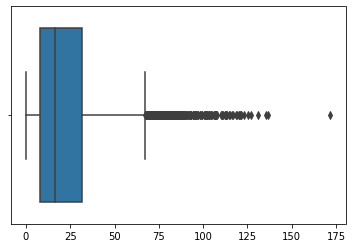

In [30]:
pred = lr.predict(X_test)
err = np.abs(y_test - pred)/60
print(err)
sns.boxplot(err)
plt.show()

In [ ]:
In my opinion, the acceptable time difference between the predictions and the actual result has to be within 10 mins in average. Also, 
the variance for the model is large.